In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import regex as re
import time

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords # Import the stop word list

import tqdm as tqdm
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [5]:
bot_comments = pd.read_csv("C:botnet_comments.csv", low_memory = False)
bot_comments.rename(columns={'reatedAt':'createdAt'},inplace=True)
bot_comments.drop(['media', 'moderationLabels', 'numReports', 'parent', 'sb','isNewUserNeedsApproval', 'isHighlighted', 'isAtFlagLimit', 'isDeletedByAuthor', 'isDeleted', 'isSpam', 'isFlagged', 'editableUntil', 'isApproved'], axis=1, inplace=True)
bot_comments['lenMessage'] = bot_comments.message.astype(str).map(lambda x: len(x))

# Username Analysis

In [6]:
from Levenshtein import distance as lev
bot_users = pd.read_csv('C:potential_social_botnets.csv')
bot_users[bot_users.username.str.match('.+2345$') == True].head(4)
# df[df['Country (region)'].str.match('^P.*')== True]

,username,email_id,email_provider_id,is_major_email_provider,email_reuse_id,password_id,is_common_password,creation_date
0,Eleanor2345,email_9794418,email_provider_14,True,email_reuse_6100,password_1003131,False,2009-11-14 00:41:42.176683-05
1,Carling2345,email_9794410,email_provider_14,True,email_reuse_6100,password_1003131,False,2009-11-11 04:27:49.997487-05
3,Courtland2345,email_9794196,email_provider_14,True,email_reuse_6100,password_1003131,False,2009-11-13 02:36:45.308864-05
5,Briana2345,email_9794243,email_provider_292,True,email_reuse_6101,password_1003131,False,2009-11-10 05:00:50.927567-05


In [7]:
# return levenshtein matrix
def lev_matrix(string1, string2):
    lenA = len(string1) + 1
    lenB = len(string2) + 1
    matrix = np.zeros((lenA, lenB))
    for i in range(lenA):
        matrix[i, 0] = i
    for j in range(lenB):
        matrix[0, j] = j
    for i in range(1, lenA):
        for j in range(1, lenB):
            a = string1[i-1]
            b = string2[j-1]
            if a == b:
                matrix[i,j] = min(matrix[i-1,j-1], matrix[i-1,j], matrix[i,j-1]+1)
            else:
                matrix[i,j] = min(matrix[i-1,j]+1, matrix[i-1,j-1]+1, matrix[i,j-1]+1)
    return matrix

# return similarity in usernames
def same(string1, string2): 
    lenA = len(string1)
    lenB = len(string2)
    shorter = min(lenA, lenB)
    return lev(string1, string2) <= (shorter)

In [8]:
print("password_662706: 'spouby78', 'spearly70'")
print(lev_matrix('spouby78', 'spearly70'))
print(same('spouby78', 'spearly70'))
print()
print("password_1048866: 'Praipleeref', 'losythult'")
print(lev_matrix('Praipleeref', 'losythult'))
print(same('Praipleeref', 'losythult'))
print()
print("password_1048864: 'liamidoma', 'praildcratt'")
print(lev_matrix("liamidoma", 'praildcratt'))
print(same("liamidoma", "praildcratt"))
print()
print("password_999325: 'Mariosmith', 'Hugubertsmith'")
print(lev_matrix('Mariosmith', 'Hugubertsmith'))
print(same('Mariosmith', 'Hugubertsmith'))
print()
print("password_1889241: 'KDordf_har_blivit_S_i_Mark', 'Mark_goda_livet_slutar'")
print(lev_matrix('KDordf_har_blivit_S_i_Mark', 'Mark_goda_livet_slutar'))
print(same('KDordf_har_blivit_S_i_Mark', 'Mark_goda_livet_slutar'))

password_662706: 'spouby78', 'spearly70'
[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [1. 0. 1. 2. 3. 4. 5. 6. 7. 8.]
 [2. 1. 0. 1. 2. 3. 4. 5. 6. 7.]
 [3. 2. 1. 1. 2. 3. 4. 5. 6. 7.]
 [4. 3. 2. 2. 2. 3. 4. 5. 6. 7.]
 [5. 4. 3. 3. 3. 3. 4. 5. 6. 7.]
 [6. 5. 4. 4. 4. 4. 4. 4. 5. 6.]
 [7. 6. 5. 5. 5. 5. 5. 5. 4. 5.]
 [8. 7. 6. 6. 6. 6. 6. 6. 5. 5.]]
True

password_1048866: 'Praipleeref', 'losythult'
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 1.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 2.  2.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 3.  3.  3.  3.  4.  5.  6.  7.  8.  9.]
 [ 4.  4.  4.  4.  4.  5.  6.  7.  8.  9.]
 [ 5.  5.  5.  5.  5.  5.  6.  7.  8.  9.]
 [ 6.  5.  6.  6.  6.  6.  6.  7.  7.  8.]
 [ 7.  6.  6.  7.  7.  7.  7.  7.  8.  8.]
 [ 8.  7.  7.  7.  8.  8.  8.  8.  8.  9.]
 [ 9.  8.  8.  8.  8.  9.  9.  9.  9.  9.]
 [10.  9.  9.  9.  9.  9. 10. 10. 10. 10.]
 [11. 10. 10. 10. 10. 10. 10. 11. 11. 11.]]
False

password_1048864: 'liamidoma', 'praildcratt'
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.

In [9]:
# all Bot networks based off their password IDs
groups = bot_users.groupby(['password_id'])
allgroups = [groups.get_group(x) for x in groups.groups]
networks = []
for group in allgroups:
    networks.append(group.username.tolist())
    print(f"Password_ID: {group.password_id.iloc[0]},\nUsers:\n{group.username}")

Password_ID: password_1003131,
Users:
0        Eleanor2345
1        Carling2345
2       Cecania23456
3      Courtland2345
4           Arlo1234
           ...      
880         Emmett45
881        Ajit32847
882     Charisma3451
883        Carey1234
884     Benquasha234
Name: username, Length: 885, dtype: object
Password_ID: password_100736,
Users:
885    JackFackleroy
886      pinkmyfloyd
887      sonofagun12
888          1290000
889       Hamsterdam
           ...      
966          1170000
967          1260000
968          1250000
969          1270000
970       merrilyfan
Name: username, Length: 86, dtype: object
Password_ID: password_1010372,
Users:
971       hoornochura
972       ChiviorkBok
973         FetCleAte
974         faineaddy
975         rearavelo
            ...      
2502        draiftimi
2503      bypeGastpes
2504        japhdardY
2505        syncabsen
2506    urillhaifsfam
Name: username, Length: 1536, dtype: object
Password_ID: password_1017429,
Users:
2507      bohuse

Password_ID: password_1814399,
Users:
94395        aspissape
94396        ArrosePsy
94397        attailiag
94398        drexelero
94399      Indererhync
             ...      
94521    ricsprearcigo
94522        Traubbeme
94523      Stabintuibe
94524    arrineInveree
94525        gribemise
Name: username, Length: 131, dtype: object
Password_ID: password_1814453,
Users:
94526    Sorkbeabeasse
94527        emencedub
94528    loapyptoscora
94529        Terascece
94530      vevyNaignee
             ...      
97181        aloneeraf
97182        Sleexynon
97183        Rhypelele
97184        awaildema
97185      Wessasiceam
Name: username, Length: 2660, dtype: object
Password_ID: password_1815177,
Users:
97186    Datlytrainats
97187        riliGlivy
97188        unutuatly
97189        addirePag
97190      BypeAreheah
             ...      
97271      Selmmaleshy
97272    sakeasceshofs
97273        Lelagaima
97274      ElaplyKeede
97275    Steetenanceni
Name: username, Length: 90, dtype: objec

Password_ID: password_362349,
Users:
194937    Ovsnozqa
194938    Qabzopzi
194939    Wznjjfjs
194940    Bdbkjieq
194941    Cqdnukrb
            ...   
195156    Qxvobwyx
195157    Ygdjdvov
195158    Udumoxxa
195159    Egkyuodi
195160    Yoyzeczh
Name: username, Length: 224, dtype: object
Password_ID: password_36238,
Users:
195161    DielajomNoima
195162        bleagsere
195163    JissinueBrurn
195164      hauhhoonesk
195165        Altecetut
              ...      
195269        Illecycle
195270        AnnesenuB
195271      WibCootahit
195272      Ceksunsosse
195273        mepcoogue
Name: username, Length: 113, dtype: object
Password_ID: password_362887,
Users:
195274       kiproderick
195275         daletracy
195276      jermainealex
195277      harleypierre
195278       henryadolfo
               ...      
195345        hongjeramy
195346        jordonrolf
195347    galecristopher
195348      mckinleylane
195349        arronwaldo
Name: username, Length: 76, dtype: object
Password_ID: p

Name: username, Length: 223, dtype: object
Password_ID: password_542248,
Users:
310289        Haceunava
310290    Swisazorstita
310291        SefeVioro
310292        DiurryBig
310293      Poriinhinia
              ...      
310686        broomsBok
310687      Glydayunulk
310688    Trogscoumsrok
310689      Grintycerie
310690    betaJenestync
Name: username, Length: 402, dtype: object
Password_ID: password_543084,
Users:
310691    Aukgrofqkf
310692    Jpnodanham
310693    Xgowmhufpk
310694    Lgvpawmqdz
310695    Fwjwehsgma
             ...    
311127    Ahpqtrewni
311128    Luloyzaqnj
311129    Oiohvvkvov
311130    Bzqqmmfjoq
311131    Vhbdmohxnd
Name: username, Length: 441, dtype: object
Password_ID: password_543155,
Users:
311132      equarleclaf
311133        Endonefem
311134      AssonaSmosy
311135      Lalquawsvaw
311136        Irrinirop
              ...      
311225    WarWhaniamerm
311226        jubbasurl
311227      ababpellura
311228        unamsnaib
311229    Lunteevetuite
N

In [10]:
# comparing levenshtein's overall accuracy with accuracy for similar username networks
total_true = 0
total_false = 0
same_true = 0
same_false = 0
for network in networks:
    res = []
    t = 0
    f = 0
    for i in range(1, len(network)):
        boolean = same(network[i-1], network[i])
        if boolean: t += 1
        else: f += 1
        res.append(boolean)
#     print(t, f)
    if t/(t+f)*100>=60:
        same_true += t
        same_false += f
    total_true += t
    total_false += f
print(f"Overall accuracy: {round(total_true/(total_false+total_true)*100, 2)}%\n\n")
print(networks[-1][:20])
print(f"Accuracy of networks such as above: {round(same_true/(same_true+same_false), 3)*100}%")

Overall accuracy: 67.78%


['Mariosmith', 'Hugubertsmith', 'Clementsmith', 'Geraintsmith', 'Viltautassmith', 'Anttonismith', 'Bedwyrsmith', 'Damianussmith1', 'Sreckosmith', 'Abdiassmith', 'Asvaldrsmith', 'Bijaysmith', 'Kjetilsmith', 'Hildredsmith', 'ihsansmith', 'Mehrdadsmith', 'Ramessusmith', 'Iuniussmith', 'Miodragsmith', 'Telesphorussmith']
Accuracy of networks such as above: 90.0%


### Levenshtein mostly works if the username format is similar. Eg.
- password_999325: Mariosmith, Hugubertsmith, and Clementsmith
- password_1003131: Eleanor2345, Briana2345, and Cedric2345

### But not in cases such as. Eg.
- password_1048866: Praipleeref, losythult, UnsofsChuff

I can either
1. Work with levenshtein and identify networks or
2. Figure out how to spot similarities in other usernames
---
Second option is close to impossible unless I can develop an algorithm that can come up with regex expressions and spot the patterns in multiple users on its own. Even then it is possible for human users to get swept up in the data.

First option I can work with these obvious bot networks and figure out what other traits are obvious apart from their usernames. Using these traits, I can try to figure out if they are present in other networks. This option will be more accurate also because the more traits the user exhibits, the more likely it is a bot.

# Further Analysis

In [11]:
total = 0
curr = 0
for group in allgroups:
#     print(f"Password_ID: {group.password_id.iloc[0]}")
    temp = pd.DataFrame({'username':group.username, 'email_provider_id':group.email_provider_id, 'creation_date':group.creation_date})
#     print(temp)
    curr += temp.email_provider_id.value_counts()[0]
    total += len(temp.email_provider_id)
print(f"Accuracy by email_provider_id: {round(curr/total * 100, 2)}%")

Accuracy by email_provider_id: 91.67%


In [12]:
dates = []
total = 0
first = 0
second = 0
for group in allgroups:
    temp = group.creation_date.astype(str).str.split(' ').str[0]
    first += temp.value_counts()[0]
    month = temp.value_counts().index[0].split('-')[1]
    total += len(temp)
    for i in range(len(temp.value_counts())):
        if temp.value_counts().index[i].split('-')[1] == month:
            second += temp.value_counts()[i]
print(f"Accuracy by creation_date of single day window: {round(first/total*100, 2)}%")
print(f"Accuracy by creation_date of one month window: {round(second/total*100, 2)}%")

Accuracy by creation_date of single day window: 40.36%
Accuracy by creation_date of one month window: 78.64%


Levenshtein's algorithm on usernames:
- Overall accuracy: 6.8%
- Accuracy on obvious usernames: 91.5%

Accuracy by email_provider_id: 91.67%

Accuracy by creation_date of users within single day window: 40.36%

Accuracy by creation_date of users within the same month window: 78.64%

The accuracy of similar email_provider_id and creation_date within a one month window is pretty high. We might be able to use these metrics to identify if a bot user is working with others based on three traits now.
- username (although low accuracy for the majority)
- email provider id
- creation date

Comments could also be another metric to decide if its a bot or not. However not all bots comment which is why this will be a less reliable algorithm to use.

1049


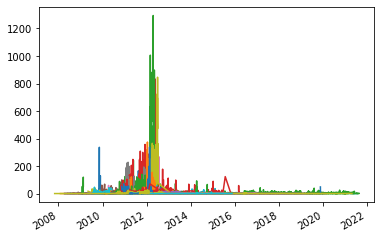

In [13]:
# all comments from bots in a list
comment_groups = []
print(len(allgroups))
for group in allgroups:
    temp = bot_comments.loc[bot_comments.username.isin(group.username)]
    comment_groups.append(temp)
    pd.to_datetime(temp.createdAt.astype(str).str.split('T').str[0]).value_counts().plot(kind='line')

Most networks made a lot of comments during the same time period. This could be another indicator of bot users working together.

In [14]:
# Comparing length of messages
greater = 0
total = 0
for group in comment_groups:
    for i in range(len(group.username.value_counts())):
        user = group.username.value_counts().index[i]
        most_commented = group.loc[group.username == user].lenMessage.value_counts().to_frame().iloc[0]
        if most_commented.lenMessage >= 5:
            greater += 1
        total += 1
#         print(f"{user} commented one message {most_commented.lenMessage} times at most.")
print(f"Accuracy: {round(greater/total*100, 2)}%")

Accuracy: 11.46%


### To identify a bot network we should first look if they correlate with other users based off their username, account creation date, comments creation date, and shared email provider. To confirm if it really is a bot, look at the type of comments created and frequency of these comments.

# Comments Analysis

In [15]:
bot_comments = pd.read_csv("C:botnet_comments.csv", low_memory = False)
bot_comments.rename(columns={'reatedAt':'createdAt'},inplace=True)
bot_comments.drop(['media', 'moderationLabels', 'numReports', 'parent', 'sb','isNewUserNeedsApproval', 'isHighlighted', 'isAtFlagLimit', 'isDeletedByAuthor', 'isDeleted', 'isSpam', 'isFlagged', 'editableUntil', 'isApproved'], axis=1, inplace=True)
bot_comments['lenMessage'] = bot_comments.message.astype(str).map(lambda x: len(x))

bot_comments = pd.merge(
    bot_comments, 
    bot_users[["username", "creation_date", "email_provider_id", "password_id"]], 
    how="left", 
    on="username"
)
bot_comments.rename(columns={"creation_date": "acct_creation_date"}, inplace=True)
bot_comments.dropna(axis='index', inplace=True)
bot_comments = bot_comments.reset_index().drop(['index'], axis=1)
bot_comments.head(10)

,username,canVote,createdAt,dislikes,forum,id,isEdited,likes,message,points,lenMessage,acct_creation_date,email_provider_id,password_id
0,theboji,False,2010-12-05T10:59:57,0,myfoxdetroit,107058805,False,0,"<p>Pot smokers think weed don't kill, it does,...",0,86,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
1,theboji,False,2010-12-08T21:44:15,0,myfoxdetroit,108812146,False,0,<p>Looks like scooby snacks is losing weight.</p>,0,49,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
2,theboji,False,2011-03-03T01:29:56,0,myfoxdetroit,159550177,False,2,<p>I know you haven't got any in over ten year...,2,99,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
3,theboji,False,2011-04-22T22:18:03,0,myfoxdetroit,190330050,False,3,<p>WHY DON'T YOU DO SOME RESEARCH BEFORE YOU O...,3,164,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
4,theboji,False,2011-04-22T19:35:34,0,myfoxdetroit,190259432,False,0,<p>I find it funny that Mitch Album is promoti...,0,215,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
5,theboji,False,2010-12-11T23:55:00,0,myfoxdetroit,110398751,False,0,<p>Jesse is involved cause he is a good friend...,0,139,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
6,theboji,False,2010-12-09T21:35:17,0,myfoxdetroit,109478855,False,0,<p>I don't think the Reverend is into your kin...,0,61,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
7,theboji,False,2011-05-08T12:45:34,0,myfoxdetroit,199689775,False,0,<p> Much better than his predecessor though!</p>,0,48,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
8,theboji,False,2011-02-21T22:40:12,0,myfoxdetroit,153587188,False,0,<p>STFU and get an education before you commen...,0,68,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
9,theboji,False,2010-12-15T04:46:29,0,myfoxdetroit,112021111,False,0,"<p>This could never happen to me, I only drive...",0,99,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821


In [16]:
def clean_text_data(data_point, data_size):
    if len(str(data_point))>0:
        sent = BeautifulSoup(str(data_point), "html.parser").get_text().lower()
        review_letters_only = re.sub("[^a-zA-Z]", " ", sent) 
    review_words = review_letters_only.split()
    stops = set(stopwords.words("english"))
    meaningful_words = []
    for w in review_words:
        if w not in stops and w != '':
            meaningful_words.append(w)
    if( (i)%15000 == 0 ):
        print(f"Cleaned {round(((i)/data_size)*100)}% of {data_size} data.")
        
    return( " ".join( meaningful_words))

In [17]:
temp = []

for i in range(len(bot_comments.message)):
    temp.append(clean_text_data(bot_comments.message[i], len(bot_comments.message)))

Cleaned 0% of 241748 data.
Cleaned 6% of 241748 data.
Cleaned 12% of 241748 data.
Cleaned 19% of 241748 data.
Cleaned 25% of 241748 data.
Cleaned 31% of 241748 data.
Cleaned 37% of 241748 data.
Cleaned 43% of 241748 data.
Cleaned 50% of 241748 data.
Cleaned 56% of 241748 data.
Cleaned 62% of 241748 data.
Cleaned 68% of 241748 data.
Cleaned 74% of 241748 data.
Cleaned 81% of 241748 data.
Cleaned 87% of 241748 data.
Cleaned 93% of 241748 data.
Cleaned 99% of 241748 data.


In [18]:
bot_comments['message'] = temp
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

In [19]:
bot_comments

,username,canVote,createdAt,dislikes,forum,id,isEdited,likes,message,points,lenMessage,acct_creation_date,email_provider_id,password_id
0,theboji,False,2010-12-05T10:59:57,0,myfoxdetroit,107058805,False,0,pot smokers think weed kill think call dope,0,86,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
1,theboji,False,2010-12-08T21:44:15,0,myfoxdetroit,108812146,False,0,looks like scooby snacks losing weight,0,49,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
2,theboji,False,2011-03-03T01:29:56,0,myfoxdetroit,159550177,False,2,know got ten years entire article moot point,2,99,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
3,theboji,False,2011-04-22T22:18:03,0,myfoxdetroit,190330050,False,3,research open pie hole st offenders see jail t...,3,164,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
4,theboji,False,2011-04-22T19:35:34,0,myfoxdetroit,190259432,False,0,find funny mitch album promoting ernie harwell...,0,215,2009-06-17 14:57:11.048353-04,email_provider_14,password_1543821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241743,IDTVXQ,False,2012-04-18T02:20:56,0,allkpop,500400529,False,14,would break records fuck wrong logic get curre...,14,162,2012-04-17 22:20:52.074432-04,email_provider_14,password_2123009
241744,Gavinvd,False,2011-02-23T06:03:29,0,kkcooltools,154458299,False,0,laser beam cm diameter distance corresponds sp...,0,234,2011-02-23 01:03:18.748929-05,email_provider_0,password_2094875
241745,geryd,False,2011-05-23T01:06:48,0,thedroidguys,209634374,False,0,google meta watch work,0,49,2011-05-22 21:04:01.852915-04,email_provider_1,password_2094875
241746,deisymarshall,False,2012-04-02T05:44:40,0,slashfilm,483303469,False,1,really wonderful trailer could wait see action,1,78,2012-04-02 01:39:40.458644-04,email_provider_14,password_1150915


In [20]:
X = bot_comments[['username', 'createdAt', 'forum', 'message']]
Y = bot_comments['password_id']
X_train, X_test, Y_train, Y_test = train_test_split(X['message'], Y, test_size = 0.3, random_state=42)
X_train = vectorizer.fit_transform(X_train)
X_train = X_train.toarray()
print(X_train.shape)
X_test = vectorizer.transform(X_test)
X_test = X_test.toarray()
print(X_test.shape)

(169223, 5000)
(72525, 5000)


In [105]:
X_test[0] != 0

array([False, False, False, ..., False, False, False])

In [21]:
vocab = vectorizer.get_feature_names_out()

In [22]:
distribution = np.sum(X_train, axis=0)
print("Printing first 20 vocab-dist pairs:")
for tag, count in zip(vocab[:20], distribution[:20]):
    print(count, tag)

Printing first 20 vocab-dist pairs:
207 abbott
210 abc
425 abhor
363 ability
1729 able
122 abortion
97 abroad
189 absolute
507 absolutely
395 absolutist
107 abu
436 abuse
106 aby
168 academic
1209 accept
110 acceptable
118 accepted
614 access
90 accessible
372 accessories


In [47]:
forest = RandomForestClassifier() 
forest.fit(X_train, Y_train)
predictions = forest.predict(X_test) 
print(f"Accuracy: {accuracy_score(Y_test, predictions)*100}%")

Accuracy: 68.04688038607377%


References:
- [Nicholas Lincoln, Social Bot Networks](https://www.kaggle.com/nicholaslincoln/social-bot-network-exploration/notebook#Examining-Bot-Likelihood-and-Semantic-Similarity)
- [Paras Varshney, Bag of Words/Random Forest](https://www.kaggle.com/blurredmachine/bag-of-words-meets-random-forest)
- [Levenshtein](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0)

In [24]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, Y_train)

SelectFromModel(estimator=RandomForestClassifier())

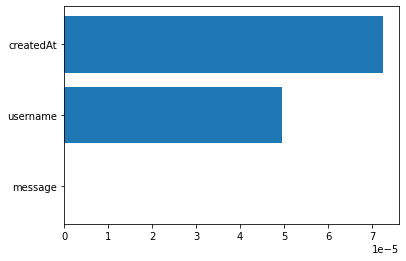

In [85]:
features = bot_comments[['username', 'createdAt', 'message']].columns.tolist()
f_i = list(zip(features,forest.feature_importances_)) 
f_i.sort(key = lambda x : x[1]) 
plt.barh([x[0] for x in f_i],[x[1] for x in f_i]) 
plt.show()

In [32]:
selected_feat= X_train.columns[(sel.get_support())]
selected_feat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Before:
- RF was binary on whether or not the password was shared,
- observations were singular rows from the potential bots dataset.
- levenshtein distance would not work pairwise (working with two models)

To do: use distance as a feature by
- average distance measure across all observations in a preprocessing step
- created some feature column based on how far the name distance was from the average in each case

- create predictor that does take in pairwise observations and predicts if two observations are in a network with each other.
- takes in features that are comparison metrics like levenshtein distance or cosine
- allows more leverage in terms of what features you create, because then you could have feature columns that are "how close together were the two accounts created" and "how closely related are the usernames" vs. having the model try to define from the distribution of the data how likely it is that an account created on Dec 1, 2014 is a bot/part of a network.

distance, cosine similarity of two vectors

In [115]:
from scipy import spatial

dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54, 13, 15]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [121]:
1 - spatial.distance.cosine(X_test[0], X_test[999])

0.0